# Using `dask` with Scanpy

`dask` is a popular out-of-core, distributed array processing library that scanpy is beginning to support.  Here we walk through a quick tutorial of using `dask` in a simple analysis task.

In [1]:
import numpy as np
import dask.distributed as dd
import dask.array as da
import scanpy as sc
import anndata as ad
import h5py
from xarray.backends import CachingFileManager
from pathlib import Path
import zarr

sc.logging.print_header()

scanpy==1.10.0rc2.dev19+ga6126980 anndata==0.10.6 umap==0.5.5 numpy==1.26.3 scipy==1.12.0 pandas==2.2.1 scikit-learn==1.4.0 statsmodels==0.14.1 igraph==0.11.3 pynndescent==0.5.11


In [3]:
if not Path("cell_atlas.h5ad").exists():
    !wget https://datasets.cellxgene.cziscience.com/82eac9c1-485f-4e21-ab21-8510823d4f6e.h5ad -O "cell_atlas.h5ad"

--2024-03-20 14:43:09--  https://datasets.cellxgene.cziscience.com/82eac9c1-485f-4e21-ab21-8510823d4f6e.h5ad
Resolving datasets.cellxgene.cziscience.com (datasets.cellxgene.cziscience.com)... 18.64.79.73, 18.64.79.72, 18.64.79.109, ...
Connecting to datasets.cellxgene.cziscience.com (datasets.cellxgene.cziscience.com)|18.64.79.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13979243997 (13G) [binary/octet-stream]
Saving to: ‘cell_atlas.h5ad’

cell_atlas.h5ad     100%[===================>]  13.02G   323MB/s    in 49s     

2024-03-20 14:43:59 (275 MB/s) - ‘cell_atlas.h5ad’ saved [13979243997/13979243997]



For more information on using distributed computing via `dask`, please see their [documentation](https://docs.dask.org/en/stable/deploying-python.html).  For example, `dask` provides direct support for [slurm](https://jobqueue.dask.org/en/latest/).  In short, one needs to define both a cluster and a client to have some degree of control over the compute resources dask will use.

In [2]:
cluster = dd.LocalCluster(n_workers=3)
client = dd.Client(cluster)
chunksize = 8_000

Dask provides extensive tooling for monitoring your computation. You can access that via the dashboard started when using any of their distributed clusters.

In [3]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 3
Total threads: 18,Total memory: 62.79 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36109,Workers: 3
Dashboard: http://127.0.0.1:8787/status,Total threads: 18
Started: Just now,Total memory: 62.79 GiB
Comm: tcp://127.0.0.1:42939,Total threads: 6
Dashboard: http://127.0.0.1:37335/status,Memory: 20.93 GiB
Nanny: tcp://127.0.0.1:46771,


We'll convert the `X` representation to `dask`.  For more info on i/o from disk, please see the `anndata` tutorials, e.g. [here](https://anndata.readthedocs.io/en/latest/tutorials/notebooks/anndata_dask_array.html) or [here](https://anndata.readthedocs.io/en/latest/tutorials/notebooks/%7Bread%2Cwrite%7D_dispatched.html).  For now, simply converting `X` will be enough to demonstrate the functionality of scanpy with dask.

**_Important Note:_** At the moment, scanpy only works with dense, `np.array` chunks in `dask` arrays.  Sparse support is a work in progress, and this tutorial will be updated accordingly when possible. 

**_Important Note:_** Pay close attention to our use of `xarray.backends.CachingFileManager` - this is needed as `dask` cannot handle pickling an `h5py.File` object!  When writing your data, it is thus advisale to use `zarr`.

In [4]:
def read_dask(file):
    f = h5py.File(file, "r")
    manager = CachingFileManager(h5py.File, file, mode="r")

    def callback(func, elem_name: str, elem, iospec):
        if iospec.encoding_type in (
            "dataframe",
            "awkward-array",
        ):
            # Preventing recursing inside of these types
            return ad.experimental.read_elem(elem)
        elif iospec.encoding_type == "array":
            return da.from_array(elem)
        elif iospec.encoding_type in ("csr_matrix", "csc_matrix"):
            shape = elem.attrs["shape"]

            def make_dask_chunk(block_id=None):
                with manager.acquire_context(needs_lock=False) as f:
                    mtx = ad.experimental.sparse_dataset(f[elem_name])
                    (row, _) = block_id
                    chunk = mtx[
                        slice(
                            row * chunksize,
                            min((row * chunksize) + chunksize, shape[0]),
                        )
                    ].toarray()
                return chunk

            chunks_0 = (chunksize,) * (shape[0] // chunksize)
            chunks_0 += (shape[0] % chunksize,)
            chunks_1 = (shape[1],)
            da_mtx = da.map_blocks(
                make_dask_chunk,
                dtype=elem["data"].dtype,
                chunks=(chunks_0, chunks_1),
                meta=np.array([]),
            )
            return da_mtx
        return func(elem)

    adata = ad.experimental.read_dispatched(f, callback=callback)
    return adata


adata_dask = read_dask("cell_atlas.h5ad")
adata_dask = adata_dask.raw.to_adata()  # Getting back to counts

Here we see a dask array:

In [5]:
adata_dask.X

dask.array<make_dask_chunk, shape=(1462702, 27714), dtype=float32, chunksize=(8000, 27714), chunktype=numpy.ndarray>

In [11]:
# TODO: Fix this or remove it

# %%time
# sc.pp.filter_cells(adata_dask, min_genes=200)
# sc.pp.filter_genes(adata_dask, min_cells=3)

MemoryError: Unable to allocate 15.6 TiB for an array with shape (2139497140804,) and data type int64

We've optimized a number of scanpy functions to be completley lazy. That means it will look like nothing is computed when you call an operation on a dask array, but only later when you hit compute.

In some cases it's currently unavoidable to skip all computation, and these cases will kick off compute for all the delayed operations immediatley.

In [6]:
%%time
sc.pp.normalize_total(adata_dask, target_sum=1e4)

CPU times: user 7.23 ms, sys: 0 ns, total: 7.23 ms
Wall time: 7.06 ms


In [7]:
%%time
sc.pp.log1p(adata_dask)

CPU times: user 4.62 ms, sys: 0 ns, total: 4.62 ms
Wall time: 5.24 ms


It can be useful to cache data, so computations don't need to be repeated.

In [8]:
# import zarr

# adata_dask.X = adata_dask.X.to_zarr("cell_atlas_normalized_X.zarr", storage_options={"consolidated": True, "compressor": zarr.Zstd()}, return_stored=True, overwrite=True)

In [8]:
adata_dask.X

dask.array<log1p, shape=(1462702, 27714), dtype=float32, chunksize=(8000, 27714), chunktype=numpy.ndarray>

In [9]:
sc.pp.highly_variable_genes(adata_dask, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [10]:
sc.pp.pca(adata_dask)

While most of the PCA computation runs immediatley, the last step (computing the observation loadings) is lazy, so must be triggered manually to avoid recomputation.

In [11]:
adata_dask.obsm["X_pca"] = adata_dask.obsm["X_pca"].compute()

In [12]:
adata_dask

AnnData object with n_obs × n_vars = 1462702 × 27714
    obs: 'celltype', 'majorType', 'City', 'sampleID', 'donor_id', 'Sample type', 'CoVID-19 severity', 'Sample time', 'Sampling day (Days after symptom onset)', 'BCR single cell sequencing', 'TCR single cell sequencing', 'Outcome', 'Comorbidities', 'COVID-19-related medication and anti-microbials', 'Leukocytes [G over L]', 'Neutrophils [G over L]', 'Lymphocytes [G over L]', 'Unpublished', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'highly_variable', 'means', 'dispersions', 

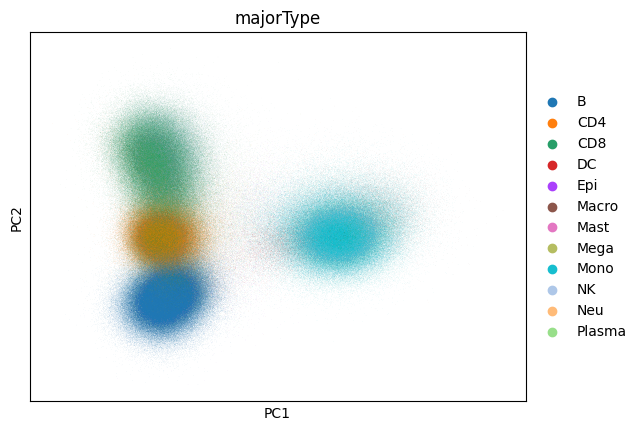

In [13]:
sc.pl.pca(adata_dask, color="majorType")

In [21]:
del adata_dask.obsp

In [25]:
# This is just a bit extra to delete later. Looking at how much faster we can make the whole pipeline:
from sklearn_ann.kneighbors.annoy import AnnoyTransformer

transformer = AnnoyTransformer(n_neighbors=15)
sc.pp.neighbors(adata_dask, transformer=transformer)
# 1m 23.5s

In [26]:
sc.tl.leiden(adata_dask, flavor="igraph", n_iterations=2)
# 2m 37.5s